In [3]:
# Necessary libraries

import os.path
import json

import pandas as pd
import matplotlib.pyplot as plt

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError



In [4]:
# If modifying these scopes, delete the file token.json.
# Set the scope to read-only for the file
# SCOPES = ["https://www.googleapis.com/auth/spreadsheets.readonly"]

# Set the scope to full control of the file
SCOPES = ["https://www.googleapis.com/auth/spreadsheets"]

# Load the Google API credentials
creds = None
if os.path.exists("token.json"):
    creds = Credentials.from_authorized_user_file("token.json", SCOPES)
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            "client_secret.json", SCOPES
        )
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open("token.json", "w") as token:
        token.write(creds.to_json())

        

In [61]:
# Function to load the ID spreadsheet ID 
def load_spreadsheet_id():
    # If modifying these scopes, delete the file token.json.
    # Set the scope to read-only for the file
    # SCOPES = ["https://www.googleapis.com/auth/spreadsheets.readonly"]

    # Set the scope to full control of the file
    SCOPES = ["https://www.googleapis.com/auth/spreadsheets"]

    # Load the Google API credentials
    creds = None
    if os.path.exists("token.json"):
        creds = Credentials.from_authorized_user_file("token.json", SCOPES)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                "client_secret.json", SCOPES
            )
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open("token.json", "w") as token:
            token.write(creds.to_json())
            
    with open("spreadsheetID.json", "r", encoding="utf-8") as sheet_id:
        spreadsheetid = json.load(sheet_id).get("spreadsheetId")
        
    service = build("sheets", "v4", credentials=creds)
    # Call the Sheets API
    sheet = service.spreadsheets()
    
    return sheet, spreadsheetid


# Function to fetch the sheet values
def get_values_sheets(sheet, spreadsheetid, range_name):    
    result = sheet.values().get(spreadsheetId=spreadsheetid, range=range_name).execute()    
    values = result.get("values", [])
    df = pd.DataFrame(values[1:], columns=values[0])
    return df


# Function to insert new values into the sheet
def insert_new_values(sheet, spreadsheetid, values, option):
    range_name = "Dados!A:Z"    
    result = sheet.values().get(spreadsheetId=spreadsheetid, range=range_name).execute()
    total_rows = result.get("values", [])
    total_rows = len(total_rows)
    result = (
        sheet.values()
        .update(spreadsheetId=spreadsheetid, 
                range=f"Dados!A{total_rows}", valueInputOption=option, body={"values": values})            
        .execute()
    )
    
    return f"{result.get('updatedRows')} rows updated."


In [24]:
sheet, spreadsheetid = load_spreadsheet_id()

In [38]:
result = sheet.get(spreadsheetId=spreadsheetid).execute()

# Obtém os nomes das abas
sheet_names = [sheet['properties']['title'] for sheet in result['sheets']]
sheet_names
    

['Dados', 'Página2']

In [43]:
range_name = "Dados!A:Z"
result = sheet.values().get(spreadsheetId=spreadsheetid, range=range_name).execute()

values = result.get("values", [])
total_rows = len(values)
total_cols = len(values[0]) if total_rows > 0 else 0

print(f"Total rows: {total_rows}\nTotal cols: {total_cols}")

Total rows: 15
Total cols: 2


In [62]:
add_values = [
    ["Dezembro/25", "R$78000,00"],
    ["Janeiro/25", "R$80000,00"],
    ["Fevereiro/25", "R$127352,00"],
]

option = "RAW"

result = insert_new_values(sheet, spreadsheetid, add_values, option)

print(result)

3 rows updated.


In [64]:
range_sheet = "Dados!A:Z"
df = get_values_sheets(sheet, spreadsheetid, range_sheet)
df

,Mês,Vendas
0,Janeiro,"R$58,915.00"
1,Feverreiro,"R$78000,00"
2,Março,"R$80000,00"
3,Abril,"R$127352,00"
4,Maio,"R$66,697.00"
5,Junho,"R$68,780.00"
6,Julho,"R$49,528.00"
7,Agosto,"R$58,897.00"
8,Setembro,"R$88,473.00"
9,Outubro,"R$22,810.00"


In [66]:
df["Vendas"] = df["Vendas"].apply(lambda x: float(str(x).replace(",", "").replace("R$", "")))

In [68]:
df.drop_duplicates(ignore_index=True, inplace=True)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mês     16 non-null     object 
 1   Vendas  16 non-null     float64
dtypes: float64(1), object(1)
memory usage: 388.0+ bytes


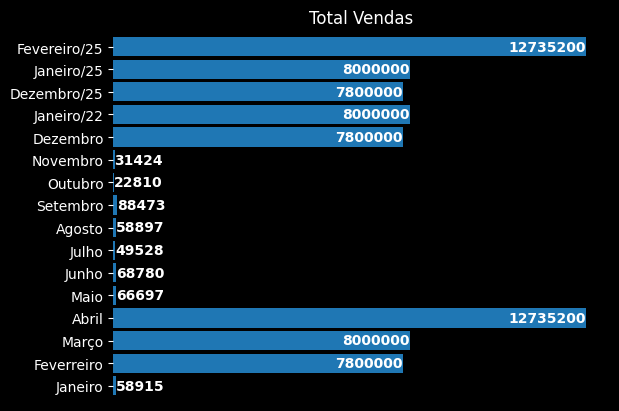

In [72]:
ax = df.plot.barh(x="Mês", y="Vendas", legend=False, width=0.85)

plt.gcf().set_facecolor('#000000')

# Removendo o quadro do gráfico
for spine in ax.spines.values():
    spine.set_visible(False)

# Add backgroud-color grafico
ax.set_facecolor("#000000")
# Removendo o eixo x
ax.get_xaxis().set_visible(False)

# Removendo o eixo Y
# ax.get_yaxis().set_visible(False)

# Alterando a cor dos ticks e rótulos do eixo Y
ax.tick_params(axis='y', colors='white')  # Cor dos ticks do eixo Y

for i in range(len(df)):
    if df["Vendas"].iloc[i] < 1000000:
        ax.text(df["Vendas"].iloc[i], i, f'{df["Vendas"].iloc[i]:.0f}', ha="left", va="center", color="white", fontweight='bold', fontsize=10)
    else:
        ax.text(df["Vendas"].iloc[i], i, f'{df["Vendas"].iloc[i]:.0f}', ha="right", va="center", color="white", fontweight='bold', fontsize=10)
        

# Removendo os rótulos dos eixos X e Y
plt.title("Total Vendas", color='white')
plt.xlabel("")  # Remove o rótulo do eixo X
plt.ylabel("")  # Remove o rótulo do eixo Y

plt.show()